<h1 style='color: green; font-size: 36px; font-weight: bold;'>Prediction Rental Prices: Brasilian houses to rent</h1>

## Importando Bibliotecas

In [1]:
# Import das bibliotecas e setting de configurações 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn import metrics 



import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 400)

%matplotlib inline
plt.rc('figure', figsize = (14, 6))

## Leitura dos dados

Importando o dataset "houses_to_rent_analisado", onde já foi realizado tratamento dos dados:

In [2]:
dataset = pd.read_csv('houses_to_rent_analisado.csv', sep=',')

Detalhando algumas informações através do metodo info:

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10660 entries, 0 to 10659
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            10660 non-null  object
 1   area            10660 non-null  int64 
 2   rooms           10660 non-null  int64 
 3   bathroom        10660 non-null  int64 
 4   parking spaces  10660 non-null  int64 
 5   floor           10660 non-null  int64 
 6   animal          10660 non-null  int64 
 7   furniture       10660 non-null  int64 
 8   hoa             10660 non-null  int64 
 9   rent amount     10660 non-null  int64 
 10  property tax    10660 non-null  int64 
 11  fire insurance  10660 non-null  int64 
 12  total           10660 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.1+ MB


## Matriz de Correlação

<AxesSubplot:>

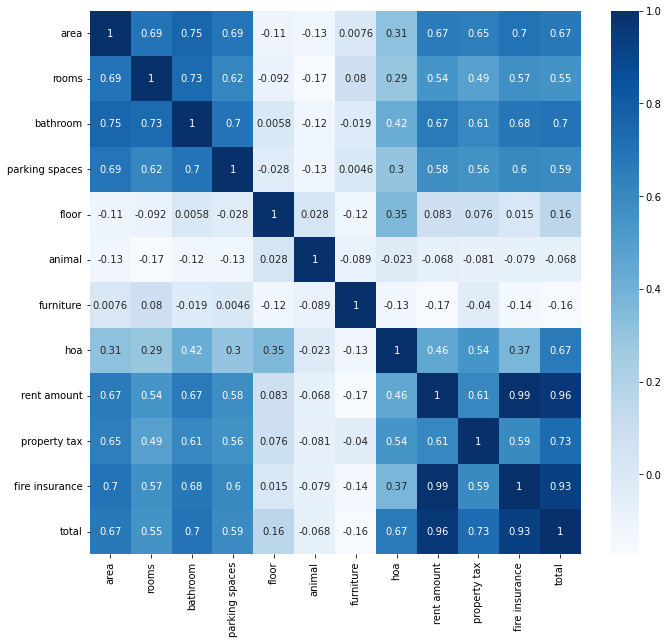

In [4]:
corr = dataset.drop(['city'], axis=1).corr()

plt.figure(figsize=(11,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="Blues", annot=True)

A coluna 'total'(valor total de aluguel), é formado a partir da soma de quatro outras colunas ('hoa', 'rend amount', 'property tax', 'fire insurance'). Então, como estamos querendo prever os valores dos imoveis, não teriamos este tipo informações, logo não utiliizaremos estas colunas por esses dois motivos.

As colunas 'animal' e 'furniture' possuiem uma baixa correlação com o 'total', logo, não utilizaremos estas features para criação do modelo. 

Retirando as colunas que não serão utilizadas:

In [28]:
dataset.loc[:,['area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'total']].corr().round(4)

,area,rooms,bathroom,parking spaces,floor,animal,furniture,total
area,1.0000,0.6938,0.7543,0.6897,-0.1105,-0.1303,0.0076,0.6732
rooms,0.6938,1.0000,0.7341,0.6165,-0.0923,-0.1726,0.0805,0.5525
bathroom,0.7543,0.7341,1.0000,0.6975,0.0058,-0.1201,-0.0186,0.6976
parking spaces,0.6897,0.6165,0.6975,1.0000,-0.0280,-0.1288,0.0046,0.5901
floor,-0.1105,-0.0923,0.0058,-0.0280,1.0000,0.0279,-0.1244,0.1615
animal,-0.1303,-0.1726,-0.1201,-0.1288,0.0279,1.0000,-0.0889,-0.0681
furniture,0.0076,0.0805,-0.0186,0.0046,-0.1244,-0.0889,1.0000,-0.1648
total,0.6732,0.5525,0.6976,0.5901,0.1615,-0.0681,-0.1648,1.0000


## Variável Dependente X Variáveis Explicativas

Utilizaremos o gráfico de dispersão entre as variáveis do dataset para ter uma visualização gráfica do comportamento variável independentes sobre a variável dependente

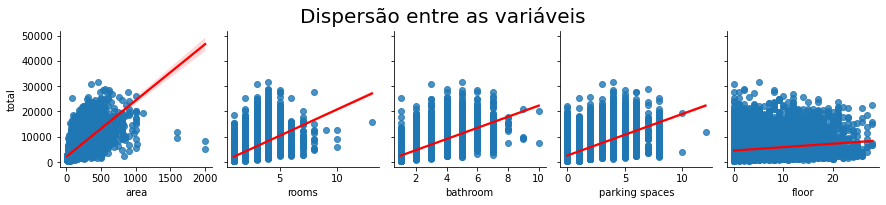

In [30]:
ax = sns.pairplot(dataset.loc[:,['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'total']],
                     y_vars='total', 
                     x_vars=['area', 'rooms', 'bathroom', 'parking spaces', 'floor'],
                     kind='reg', 
                     plot_kws={'line_kws':{'color':'red'}})
ax.fig.suptitle("Dispersão entre as variáveis", fontsize=20, y=1.1) # o argumento y indica a posição do titulo em relação ao eixo y
plt.show()

Através do gráfico é possível perceber que todas as variáveis independentes possui uma tendência positiva.  A 'area' possui uma tendencia mais proxima de ser uma relação linear em relação as outras, já que seus dados são menos dispersos.

## Codificação categórica (OneHotEncoder)

A feature 'city' é uma variável categórica, logo, não pode ser utilizada como feature para criação de um modelo de Machine Learning. Para poder utilizar esta feature vai ser aplicado a One-hot encoding.

In [3]:
encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded = encoder.fit_transform(dataset[['city']])
df_encoded.head()

,city_São Paulo,city_Porto Alegre,city_Rio de Janeiro,city_Campinas,city_Belo Horizonte
0,1,0,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0


Concatenando o dataset das cidades com o cojunto de dados e dropando a feature 'city':

In [4]:
dataset = dataset.drop('city',axis=1)
dataset = pd.concat([dataset, df_encoded], axis=1)
dataset.head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total,city_São Paulo,city_Porto Alegre,city_Rio de Janeiro,city_Campinas,city_Belo Horizonte
0,70,2,1,1,7,0,0,2065,3300,211,42,5618,1,0,0,0,0
1,320,4,4,0,20,0,1,1200,4960,1750,63,7973,1,0,0,0,0
2,80,1,1,1,6,0,1,1000,2800,0,41,3841,0,1,0,0,0
3,51,2,1,0,2,0,1,270,1112,22,17,1421,0,1,0,0,0
4,25,1,1,0,1,1,1,0,800,25,11,836,1,0,0,0,0


## Padronização do Conjunto de Dados

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10660 entries, 0 to 10659
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   area                 10660 non-null  int64
 1   rooms                10660 non-null  int64
 2   bathroom             10660 non-null  int64
 3   parking spaces       10660 non-null  int64
 4   floor                10660 non-null  int64
 5   animal               10660 non-null  int64
 6   furniture            10660 non-null  int64
 7   hoa                  10660 non-null  int64
 8   rent amount          10660 non-null  int64
 9   property tax         10660 non-null  int64
 10  fire insurance       10660 non-null  int64
 11  total                10660 non-null  int64
 12  city_São Paulo       10660 non-null  int64
 13  city_Porto Alegre    10660 non-null  int64
 14  city_Rio de Janeiro  10660 non-null  int64
 15  city_Campinas        10660 non-null  int64
 16  city_Belo Horizonte  1

In [5]:
features = dataset.loc[:,['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'animal', 'furniture', 'city_São Paulo', 'city_Porto Alegre', 'city_Rio de Janeiro', 'city_Campinas', 'city_Belo Horizonte']]
features_list = list(features.columns)

Sendo os dados de ordens de magnitude diferente, iremos normalizar todo o conjunto de dados para evitar que algumas features dominem a função objetivo e atrapalhe o estimador.

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaler.fit(features)
features_norm = scaler.transform(features)

In [7]:
df_features_norm = pd.DataFrame(features_norm, columns=features_list)
df_features_norm.head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,city_São Paulo,city_Porto Alegre,city_Rio de Janeiro,city_Campinas,city_Belo Horizonte
0,0.029663,0.083333,0.000000,0.083333,0.250000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.155354,0.250000,0.333333,0.000000,0.714286,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.034691,0.000000,0.000000,0.083333,0.214286,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.020111,0.083333,0.000000,0.000000,0.071429,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.007039,0.000000,0.000000,0.000000,0.035714,1.0,1.0,1.0,0.0,0.0,0.0,0.0


## Recalculando a correlação

<AxesSubplot:>

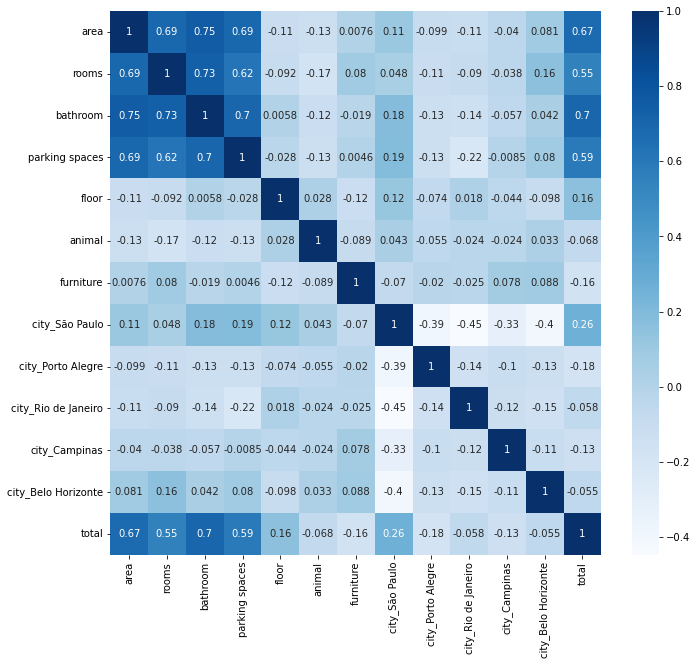

In [34]:
df_features_norm['total'] = dataset['total']
corr = df_features_norm.corr()

plt.figure(figsize=(11,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="Blues", annot=True)

## Regressão Linear (Linear Regression)

In [35]:
X = features_norm
y = dataset['total']

O erro quadrático médio (MSE) mede a média dos quadrados dos erros, ou seja, a diferença quadrática média entre os valores estimados e o valor real. 

In [54]:
linear_regression = LinearRegression()
scores = cross_val_score(linear_regression, X, y, cv=10, scoring='neg_mean_squared_error')  # neg_mean_squared_error calcula o erro quadrático médio
print(f'f1_score:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

f1_score:[-8722013.37242026 -7661697.98405253 -7642389.99437148 -7577279.7804878
 -7530137.94935671 -7500724.12570356 -7258322.63628155 -6992155.78022065
 -6960271.20075047 -5753602.42018631]
Média: -7359859.524383133
Desvio Padrão: 707654.6240853556


In [57]:
linear_regression = LinearRegression()
scores = cross_val_score(linear_regression, X, y, cv=10, scoring='r2')  # coeficiente de determinação
print(f'f1_score:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

f1_score:[0.58962562 0.60106538 0.60637829 0.60924718 0.62056057 0.63207722
 0.63537198 0.64201187 0.64283086 0.65075351]
Média: 0.6229922490404454
Desvio Padrão: 0.019562160635825884


## XGBRegressor

XGBoost é uma biblioteca otimizada de aumento de gradiente distribuída projetada para ser altamente eficiente, flexível e portátil. Ele implementa algoritmos de aprendizado de máquina sob a estrutura Gradient Boosting. O XGBoost fornece um reforço de árvore paralela (também conhecido como GBDT, GBM) que resolve muitos problemas de ciência de dados de maneira rápida e precisa.

Gradient Boosting fornece um modelo de previsão na forma de um conjunto de modelos de previsão fracos, que normalmente são árvores de decisão. Quando uma árvore de decisão é o aprendiz fraco, o algoritmo resultante é chamado de árvores impulsionadas por gradiente; geralmente supera a floresta aleatória . Um modelo de árvores impulsionado por gradiente é construído de maneira faseada como em outros métodos de impulsionamento, mas generaliza os outros métodos permitindo a otimização de um função de perda diferenciável.

Fonte: https://xgboost.readthedocs.io/en/stable/index.html

In [58]:
xgb = XGBRegressor(base_score=0.5, verbose=False)
scores = cross_val_score(xgb, X, y, cv=10, scoring='r2')  # coeficiente de determinação
print(f'f1_score:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

[11:09:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a fa

## CatBoostRegressor

O CatBoost é um nova tecinica de aumento de gradiente. O CatBoost a superar outras implementações de aprimoramento disponíveis publicamente em termos de qualidade em uma variedade de conjuntos de dados. Dois avanços algorítmicos críticos introduzidos no CatBoost são a implementação de reforço ordenado, uma alternativa orientada por permutação ao algoritmo clássico e um algoritmo inovador para processar recursos categóricos. Ambas as técnicas foram criadas para combater uma mudança de previsão causada por um tipo especial de vazamento de alvo presente em todas as implementações atualmente existentes de algoritmos de aumento de gradiente.

Fonte: https://catboost.ai/en/docs/

In [59]:
catboost_model = CatBoostRegressor(verbose=False)
scores = cross_val_score(catboost_model, X, y, cv=10, scoring='r2')  # coeficiente de determinação
print(f'f1_score:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

f1_score:[0.67057683 0.68418227 0.68867758 0.68977287 0.69349679 0.69439148
 0.70139893 0.70999003 0.7188254  0.72505338]
Média: 0.6976365563584797
Desvio Padrão: 0.015653843738514164


## Modelos para a cidade de São Paulo

In [18]:
dataset_sao_paulo = dataset[dataset['city_São Paulo'] == 1].drop(['city_São Paulo', 'city_Porto Alegre', 'city_Rio de Janeiro', 'city_Campinas', 'city_Belo Horizonte'], axis=1)
features_sao_paulo = dataset_sao_paulo.loc[:,['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'animal', 'furniture']]
features_list_sao_paulo = list(features.columns)

scaler = MinMaxScaler(feature_range=(0, 1)) 
scaler.fit(features_sao_paulo)
features_norm_sao_paulo = scaler.transform(features_sao_paulo)

X_sao_paulo = features_norm_sao_paulo
y_sao_paulo = dataset[dataset['city_São Paulo'] == 1]['total']

df_features_norm = pd.DataFrame(features_norm_sao_paulo, columns=features_list_sao_paulo)
df_features_norm.head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture
0,0.037130,0.111111,0.000000,0.083333,0.250000,0.0,0.0
1,0.194462,0.333333,0.333333,0.000000,0.714286,0.0,1.0
2,0.008811,0.000000,0.000000,0.000000,0.035714,1.0,1.0
3,0.229704,0.222222,0.222222,0.583333,0.000000,0.0,1.0
4,0.127124,0.333333,0.333333,0.333333,0.142857,0.0,1.0


In [20]:
linear_regression = LinearRegression()
scores = cross_val_score(linear_regression, X_sao_paulo, y_sao_paulo, cv=10, scoring='r2')  # coeficiente de determinação
print(f'f1_score:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

f1_score:[0.55203994 0.5728456  0.57730627 0.58465139 0.58553841 0.58958793
 0.62190994 0.62712254 0.65048646 0.67873225]
Média: 0.6040220736162996
Desvio Padrão: 0.037292383099102246


In [21]:
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(verbose=False)
scores = cross_val_score(catboost_model, X_sao_paulo, y_sao_paulo, cv=10, scoring='r2')  # coeficiente de determinação
print(f'f1_score:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

f1_score:[0.62740142 0.65892796 0.65911314 0.66443445 0.67060108 0.67281177
 0.68029837 0.68461964 0.68606673 0.70850812]
Média: 0.6712782664817661
Desvio Padrão: 0.020345665845234954
